# Author : Priyanka Sakhare
**GRIP @ The Sparks Foundation**

**Task #7 : Stock Market Prediction using Numerical and Textual Analysis**

**Objective: Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines**

Stock to analyze and predict - SENSEX (S&P BSE SENSEX)

● Download historical stock prices from finance.yahoo.com

● Download textual (news) data from https://bit.ly/36fFPI6


### The task demands to form a model using the Numerical as well as Textual analysis of Stock Market Prices and News Headlines respectively. 

## Importing the required libraries :

In [3]:
!pip3 install keras
!pip3 install tensorflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM,Dropout,Activation
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

  Using cached tensorflow-2.5.0-cp38-cp38-win_amd64.whl (422.6 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached h5py-3.1.0-cp38-cp38-win_amd64.whl (2.7 MB)
  Attempting uninstall: h5py
    Found existing installation: h5py 3.3.0
    Uninstalling h5py-3.3.0:
      Successfully uninstalled h5py-3.3.0


#### Incase you don't have 'vader_lexicon' package of nltk downloaded, we can run the dollowing snippet : 

###### This is important for SentimentIntensityAnalyzer from nltk.sentiment.vader

# Load the Datasets 

<b>'BSESN.csv'</b> has downloaded from https://bit.ly/3kXTdox and 
<b>'india-news-headlines.csv'</b> has been downloaded from https://bit.ly/3kXTdox 


In [5]:
stock_price = pd.read_csv('E:\BSESN.csv')
headlines = pd.read_csv('E:\india-news-headlines.csv')

## Preliminary actions on stock_price dataset :

In [6]:
stock_price.shape

(252, 7)

##### Checking for null values and dropping the respective rows(if any) :

In [7]:
stock_price.isna().sum()

Date         0
Open         2
High         2
Low          2
Close        2
Adj Close    2
Volume       2
dtype: int64

In [8]:
stock_price.dropna(axis=0,inplace=True)

#### Converting the Date column of stock_prices to DateTime object to arrange the given prices according to the date in increasing order :

In [9]:
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()
stock_price.sort_values('Date',ascending=True)
stock_price.set_index('Date',inplace=True)
stock_price.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0


## Preliminary actions on headlines dataset :

#### Checking if any value is duplicated and dropping the rows with duplicate values (if any) :

In [10]:
headlines.duplicated().sum()

24191

In [11]:
headlines = headlines.drop_duplicates()
headlines.head(5)

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


#### Checking for null values and dropping the respective rows (if any) :

In [12]:
headlines.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

#### Selecting only the 'publish_date' and 'headline_text column' from headlines dataset :

In [13]:
headlines = headlines.filter(['publish_date','headline_text'])

#### As the date in publish_date column is not in right format, so we first bring it to the right format by string manipulation and later convert it to DateTime object :

In [14]:
headlines['publish_date'] = headlines['publish_date'].astype(str)
headlines['publish_date'] = headlines['publish_date'].apply(lambda x : x[0:4]+'-'+x[4:6]+'-'+x[6:])
headlines['publish_date'] = pd.to_datetime(headlines['publish_date']).dt.normalize()

#### Grouping the headlines accordding to the publish_date so that all the headlines for a particular date can be kept in a single row, thus reducing the dimensionality of the dataset :

In [15]:
headlines = headlines.groupby('publish_date')['headline_text'].apply(lambda x : ''.join(x)).reset_index()

#### Changing the index of headlines dataset to 'publish_date' column and sorting the values according to increasing value of index : 

In [16]:
headlines.set_index('publish_date',inplace=True)
headlines.sort_index()

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,Powerless north India gropes in the darkThink ...
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


## Concatenating both the datasets to form the required dataframe 'df' :
### Dropping the rows with null values taht may occur due to dissimilar index values .

In [17]:
df = pd.concat([stock_price,headlines],axis=1)
df.dropna(axis=0,inplace=True)
df.head(10)

,Open,High,Low,Close,Adj Close,Volume,headline_text
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,After Jagannath Temple; Puri beach devpt plan ...
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,What is Citizenship (Amendment) Bill 2019: All...
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,Only 61% of CCA covered after revamp of canals...
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,I'm done playing the good girl; I want to be a...
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,Weekly Horoscope; December 22-28: Check predic...
2019-12-24,41684.511719,41702.980469,41423.070313,41461.261719,41461.261719,4400.0,Choker necklaces make for some sassy throwback...
2019-12-26,41543.800781,41543.800781,41132.890625,41163.761719,41163.761719,5600.0,NIT-T develops cold storage system for storing...
2019-12-27,41297.078125,41611.269531,41264.921875,41575.140625,41575.140625,6100.0,All schools in Naintial to be closed for two d...
2019-12-30,41686.269531,41714.730469,41453.378906,41558.000000,41558.000000,5700.0,Kareena Kapoor is holidaying in Switzerland an...
2019-12-31,41607.488281,41607.488281,41184.730469,41253.738281,41253.738281,5600.0,55 Sikhs booked for Shahidi Diwas marchEx-stud...


#### Pre-requisite : We need 'vader_lexicon' package for SentimentIntensityAnalyzer

### Detecting the compound sentiment of the headline_texts and saving the value in 'compound' column of 'df' :

In [18]:

sid = SentimentIntensityAnalyzer()

df['compound'] = df['headline_text'].apply(lambda x : sid.polarity_scores(x)['compound'])
df.head(5)

,Open,High,Low,Close,Adj Close,Volume,headline_text,compound
2019-12-17,41052.359375,41401.648438,41005.179688,41352.171875,41352.171875,19000.0,After Jagannath Temple; Puri beach devpt plan ...,-1.0000
2019-12-18,41442.750000,41614.769531,41358.468750,41558.570313,41558.570313,24300.0,What is Citizenship (Amendment) Bill 2019: All...,-0.9999
2019-12-19,41571.820313,41719.289063,41456.398438,41673.921875,41673.921875,33300.0,Only 61% of CCA covered after revamp of canals...,-0.9997
2019-12-20,41746.199219,41809.960938,41636.109375,41681.539063,41681.539063,33600.0,I'm done playing the good girl; I want to be a...,-0.9999
2019-12-23,41548.261719,41701.621094,41474.609375,41642.660156,41642.660156,6200.0,Weekly Horoscope; December 22-28: Check predic...,-0.9997


#### Checking for null values if any :

In [19]:
df.isnull().sum()

Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
headline_text    0
compound         0
dtype: int64

### EDA of the dataset :

In [20]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,compound
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,37804.237375,38071.182859,37422.826992,37745.454117,37745.454117,19134.000000,-0.991419
std,4507.985769,4380.974060,4647.212947,4535.304336,4535.304336,16540.261333,0.126305
min,26499.810547,27462.869141,25638.900391,25981.240234,25981.240234,0.000000,-1.000000
25%,34369.659179,34779.932618,33975.389648,34257.097656,34257.097656,13125.000000,-0.999900
50%,38489.480469,38750.359375,38234.869140,38425.974610,38425.974610,17000.000000,-0.999700
75%,41179.222656,41376.482422,41023.923828,41135.233399,41135.233399,21075.000000,-0.999500
max,46774.320313,46992.570313,46627.601563,46890.339844,46890.339844,188300.000000,0.997400


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2019-12-17 to 2020-12-17
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           250 non-null    float64
 1   High           250 non-null    float64
 2   Low            250 non-null    float64
 3   Close          250 non-null    float64
 4   Adj Close      250 non-null    float64
 5   Volume         250 non-null    float64
 6   headline_text  250 non-null    object 
 7   compound       250 non-null    float64
dtypes: float64(7), object(1)
memory usage: 17.6+ KB


#### Plotting the close price for every date of the dataframe df :

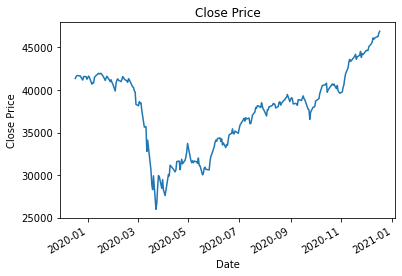

In [22]:
df['Close'].plot()
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

#### Shifting the index by 7 rows with the mean value to see the change in plot for the close price in this condition :

The NaN values are just for visualization purpose to see the rigidness of stock_price on a week gap.

In [23]:
df.rolling(7).mean().head(20)

,Open,High,Low,Close,Adj Close,Volume,compound
2019-12-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,41512.814732,41642.010045,41355.246652,41504.840960,41504.840960,18057.142857,-0.999857
2019-12-27,41547.774554,41671.955915,41392.352679,41536.693639,41536.693639,16214.285714,-0.999843
2019-12-30,41582.563058,41686.236049,41405.911272,41536.612165,41536.612165,13557.142857,-0.999843
2019-12-31,41587.658482,41670.264509,41367.101563,41476.585938,41476.585938,9600.000000,-0.999871


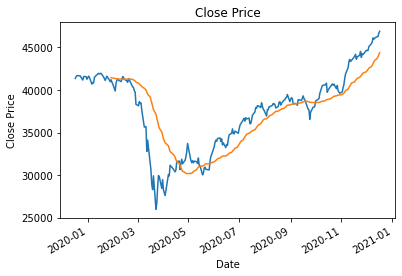

In [24]:
df['Close'].plot()
df.rolling(window=30).mean()['Close'].plot()
plt.title('Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

## Creating the required part for Train set and Test set :

#### We are going to make a model to predict stock price for the next day after an observation.

In [25]:
use_data_size = len(df) - 1
train_data_size = int(0.8 * use_data_size)
total_data_size = len(df)
start_point = total_data_size - use_data_size
print("Length of Training Set is ",train_data_size)
print('Length of Testing Set is ', total_data_size - train_data_size)

Length of Training Set is  199
Length of Testing Set is  51


#### Separating the columns for to make the required dataframe later :

In [26]:
close_price = df.iloc[start_point:total_data_size,3]
compound = df.iloc[start_point:total_data_size,7]
open_price = df.iloc[start_point:total_data_size,0]
high = df.iloc[start_point:total_data_size,1]
low = df.iloc[start_point:total_data_size,2]
volume = df.iloc[start_point:total_data_size,5]

#### As we are going to predict the value for each succeeding day, so we need to shift the close_price as well as compound Series from dataframes to the next day :

In [27]:
close_price_shifted = close_price.shift(-1)
compound_shifted = compound.shift(-1)

#### Concatenating all the Series to form the required dataframe for our model  :

In [28]:
stock_price_data = pd.DataFrame({
    'close':close_price,
    'close_price_shifted':close_price_shifted,
    'compound':compound,
    'compound_shifted':compound_shifted,
    'open':open_price,
    'high':high,
    'low':low,
    'volume':volume
                                })

In [29]:
stock_price_data.head()

,close,close_price_shifted,compound,compound_shifted,open,high,low,volume
2019-12-18,41558.570313,41673.921875,-0.9999,-0.9997,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,41681.539063,-0.9997,-0.9999,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,41642.660156,-0.9999,-0.9997,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,41461.261719,-0.9997,-0.9999,41548.261719,41701.621094,41474.609375,6200.0
2019-12-24,41461.261719,41163.761719,-0.9999,-0.9999,41684.511719,41702.980469,41423.070313,4400.0


#### Checking for null values in stock_price_data dataframe and dropping the respective rows (if any) :

In [30]:
stock_price_data.isnull().sum()

close                  0
close_price_shifted    1
compound               0
compound_shifted       1
open                   0
high                   0
low                    0
volume                 0
dtype: int64

In [31]:
stock_price_data.dropna(axis=0,inplace=True)

#### Creating the output variable (here, teh close_price_shifted or close_price after one day) as y:

In [32]:
y = stock_price_data['close_price_shifted']
y.shape

(248,)

#### Creating the predictor variables by dropping the 'close_price_shifted' column from stock_price_data : 

In [33]:
x = stock_price_data.drop(['close_price_shifted'],axis=1)
x.head()

,close,compound,compound_shifted,open,high,low,volume
2019-12-18,41558.570313,-0.9999,-0.9997,41442.750000,41614.769531,41358.468750,24300.0
2019-12-19,41673.921875,-0.9997,-0.9999,41571.820313,41719.289063,41456.398438,33300.0
2019-12-20,41681.539063,-0.9999,-0.9997,41746.199219,41809.960938,41636.109375,33600.0
2019-12-23,41642.660156,-0.9997,-0.9999,41548.261719,41701.621094,41474.609375,6200.0
2019-12-24,41461.261719,-0.9999,-0.9999,41684.511719,41702.980469,41423.070313,4400.0


#### Scaling the variables to keep the value between -1 to 1 using MinMaxScaler inorder to restrict huge changes in data :

In [34]:
scaler = preprocessing.MinMaxScaler(feature_range=(-1,1))
y = scaler.fit_transform(np.array(y).reshape(-1,1))
x = scaler.fit_transform(x)

#### Creating the Training Set and Testing Set :

In [35]:
X_train = x[:train_data_size,]
X_test = x[train_data_size + 1: len(x),]
y_train = y[:train_data_size,]
y_test = y[train_data_size + 1 : len(y),]
print('Size of Training set X : ',X_train.shape)
print('Size of Test set X : ',X_test.shape)
print('Size of Training set Y : ',y_train.shape)
print('Size of Testing set Y : ',y_test.shape)

Size of Training set X :  (199, 7)
Size of Test set X :  (48, 7)
Size of Training set Y :  (199, 1)
Size of Testing set Y :  (48, 1)


#### Reshaping the X_train and X_test to 3D arrays for the model :


In [36]:
X_train = X_train.reshape(-1,7,1)
X_test = X_test.reshape(-1,7,1)

## Creating the model :

#### Here, as the question demands to learn from it's past values , so we will go for LSTM layers or RNN analogy to perform our task.

In [37]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, activation='tanh',input_shape= X_train.shape[1:]))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100,return_sequences=False,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
dropout (Dropout)            (None, 7, 100)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 100)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

## Fitting the model on Training Set as well as checking it's performance on Test set :

In [38]:
model.compile(optimizer='rmsprop',loss='mse')
history = model.fit(X_train,y_train, epochs=20, batch_size=10, validation_data=(X_test,y_test))

Epoch 1/20
20/20 [==============================] - 33s 100ms/step - loss: 0.1003 - val_loss: 0.0210
Epoch 2/20
20/20 [==============================] - 0s 11ms/step - loss: 0.0122 - val_loss: 0.0190
Epoch 3/20
20/20 [==============================] - 0s 15ms/step - loss: 0.0157 - val_loss: 0.0231
Epoch 4/20
20/20 [==============================] - 0s 15ms/step - loss: 0.0115 - val_loss: 0.0217
Epoch 5/20
20/20 [==============================] - 0s 15ms/step - loss: 0.0135 - val_loss: 0.0265
Epoch 6/20
20/20 [==============================] - 0s 15ms/step - loss: 0.0090 - val_loss: 0.0252
Epoch 7/20
20/20 [==============================] - 0s 14ms/step - loss: 0.0091 - val_loss: 0.0294
Epoch 8/20
20/20 [==============================] - 0s 16ms/step - loss: 0.0090 - val_loss: 0.0254
Epoch 9/20
20/20 [==============================] - 0s 12ms/step - loss: 0.0083 - val_loss: 0.0301
Epoch 10/20
20/20 [==============================] - 0s 17ms/step - loss: 0.0106 - val_loss: 0.0339
Epoch 1

## Plot of Loss vs Epoch for the given Model :

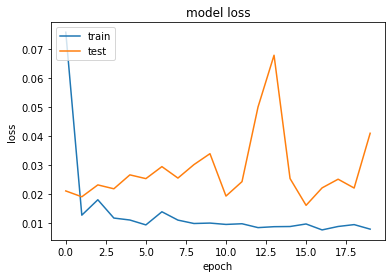

In [39]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model and respective Weights :

In [40]:
model_json = model.to_json()
with open('model.json','w') as file :
    file.write(model_json)
model.save_weights('model.h5')

### THANK YOU